In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
prices = pd.read_csv('../data/train_data.csv')

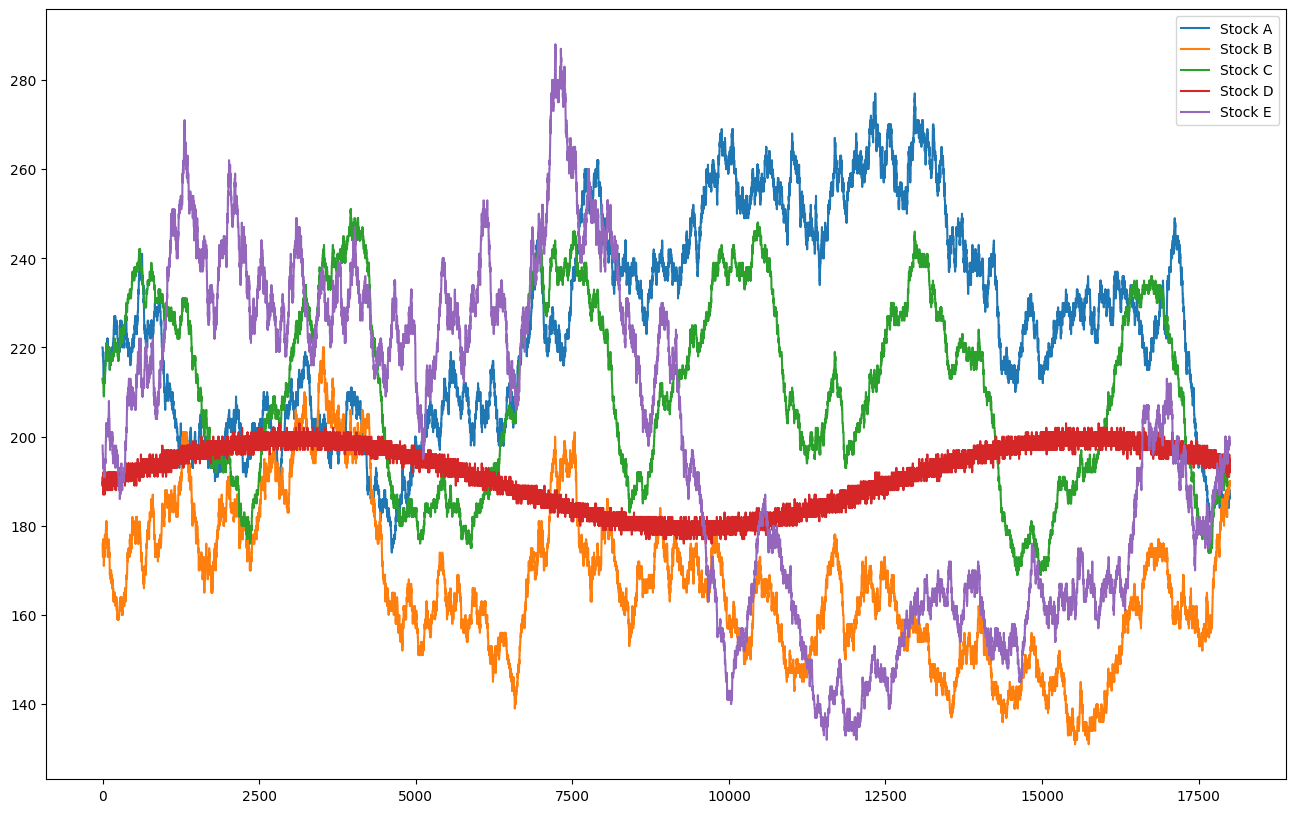

In [7]:
plt.figure(figsize=(16,10))
plt.plot(prices["StockA_Price"], label = 'Stock A')
plt.plot(prices["StockB_Price"], label = 'Stock B')
plt.plot(prices["StockC_Price"], label = 'Stock C')
plt.plot(prices["StockD_Price"], label = 'Stock D')
plt.plot(prices["StockE_Price"], label = 'Stock E')
plt.legend()

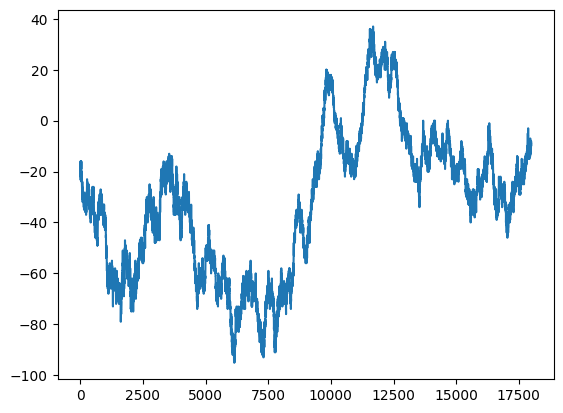

In [198]:
plt.plot(prices["StockB_Price"][5:].to_numpy() - prices["StockE_Price"][5:].to_numpy())

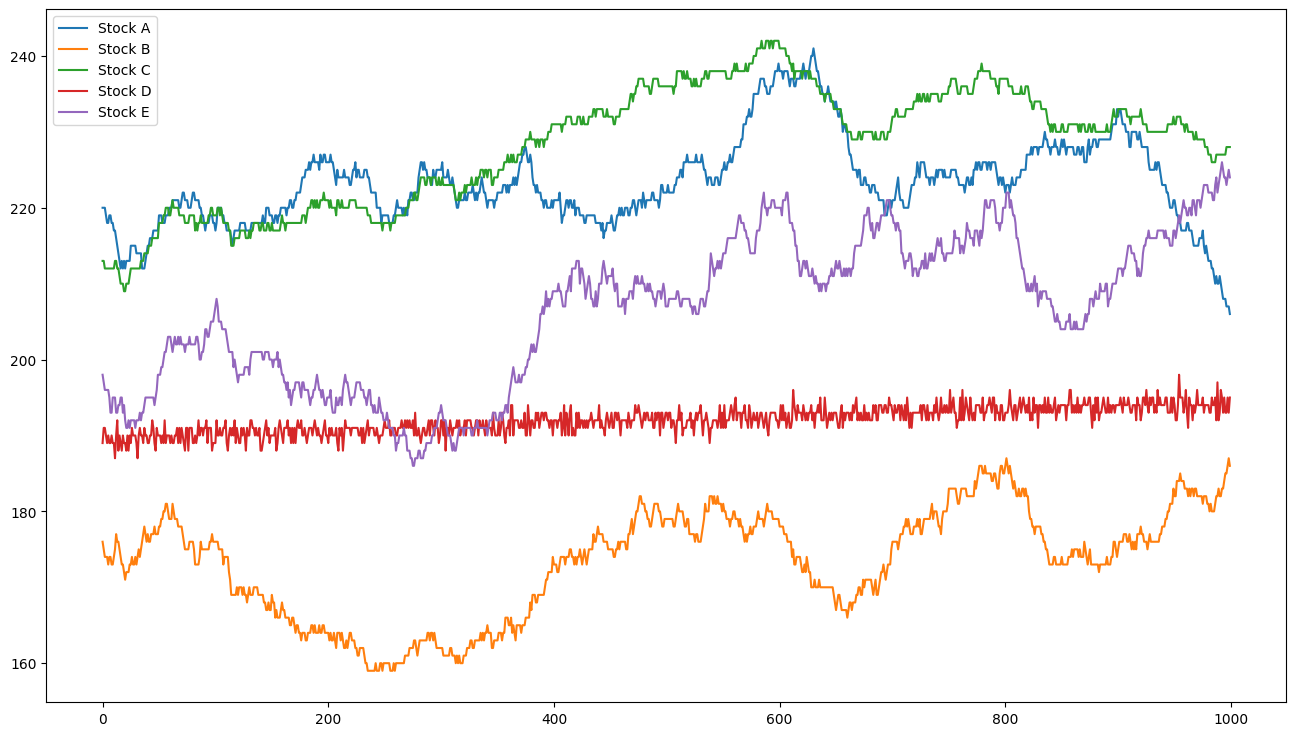

In [65]:
plt.figure(figsize=(16, 9))
plt.plot(prices['StockA_Price'][:1000], label = 'Stock A')
plt.plot(prices["StockB_Price"][:1000], label = 'Stock B')
plt.plot(prices["StockC_Price"][:1000], label = 'Stock C')
plt.plot(prices["StockD_Price"][:1000], label = 'Stock D')
plt.plot(prices["StockE_Price"][:1000], label = 'Stock E')
plt.legend()
plt.show()

In [70]:
def timelag(stock, ticks):
    '''Returns a lagged version of the stock to be used in regression.
    stock: a letter (e.g. StockA_Price is A)
    ticks: how many ticks back to shift the stock'''
    return prices[f'Stock{stock}_Price'].shift(ticks)[ticks:].to_numpy()

In [71]:
def delta(stock, ticks):
    return timelag(stock, 0)[ticks:] - timelag(stock, ticks)

In [ ]:
ticks = 10
data = {'B': delta('B', ticks)[:-5], 'E': delta('E', ticks)[5:]}
df = pd.DataFrame(data, columns=[*'BE'])
df.corr()

,B,E
B,1.000000,0.488225
E,0.488225,1.000000


In [72]:
ticks = 10
data = {'A': delta('A', ticks), 'B': delta('B', ticks), 'C': delta('C', ticks), 'E': delta('E', ticks)}
df = pd.DataFrame(data, columns=[*'ABCE'])
df.corr()

,A,B,C,E
A,1.000000,-0.013462,0.516258,-0.028958
B,-0.013462,1.000000,0.765465,0.261983
C,0.516258,0.765465,1.000000,0.195075
E,-0.028958,0.261983,0.195075,1.000000


10 ticks:

A and C correlated (r = 0.5)

B and C correlated (r = 0.8)

B and E correlated (r = 0.26)

C and E correlated (r = 0.2)

In [145]:
from sklearn import linear_model

predictors = []
for i in range(2,4):
    predictors += [('A', i), ('B', i), ('C', i), ('E', i)]
predict = ('A', 1)
y = delta(*predict)
max_lag = len(y) - min([len(delta(stock, 1)[delay:]) for stock, delay in predictors])
X = pd.DataFrame()
for stock, ticks in predictors:
    X[(stock, ticks)] = (a := delta(stock, 1))[max_lag - ticks : len(a) - ticks]
y = y[max_lag:]

In [146]:
aggregate = pd.DataFrame(X, columns = predictors)
aggregate[predict] = y
aggregate.corr()

,"(A, 2)","(B, 2)","(C, 2)","(E, 2)","(A, 3)","(B, 3)","(C, 3)","(E, 3)","(A, 1)"
"(A, 2)",1.000000,-0.002595,0.367349,-0.008991,-0.129207,-0.006357,-0.002458,-0.006333,0.005404
"(B, 2)",-0.002595,1.000000,0.539665,-0.007976,0.003137,-0.129993,0.004507,0.001027,0.001167
"(C, 2)",0.367349,0.539665,1.000000,-0.017305,0.011817,0.006084,-0.191589,0.006096,-0.002234
"(E, 2)",-0.008991,-0.007976,-0.017305,1.000000,-0.001251,-0.005685,-0.004326,-0.100841,-0.000234
"(A, 3)",-0.129207,0.003137,0.011817,-0.001251,1.000000,-0.002595,0.367349,-0.008991,-0.012863
"(B, 3)",-0.006357,-0.129993,0.006084,-0.005685,-0.002595,1.000000,0.539640,-0.007896,0.001972
"(C, 3)",-0.002458,0.004507,-0.191589,-0.004326,0.367349,0.539640,1.000000,-0.017305,0.003676
"(E, 3)",-0.006333,0.001027,0.006096,-0.100841,-0.008991,-0.007896,-0.017305,1.000000,0.001329
"(A, 1)",0.005404,0.001167,-0.002234,-0.000234,-0.012863,0.001972,0.003676,0.001329,1.000000


In [132]:
model = linear_model.LinearRegression()
model.fit(X, y)
model.coef_

array([-0.00550616, -0.00378864,  0.00658138, -0.00198969])

In [ ]:
from scipy.stats import pearsonr
max_lag = 20
blags = np.array([delta('B', 10)[max_lag-i:-i] for i in range(1, max_lag+1)])
modelE = linear_model.LinearRegression().fit(blags.T, delta('E', 10)[max_lag:])
print(modelE.coef_)
print(pearsonr(modelE.predict(blags.T), delta('E', 10)[max_lag:]))

[ 0.01473619 -0.00127842  0.03228267  0.08388769  0.48257665]
PearsonRResult(statistic=np.float64(0.49106341919083313), pvalue=np.float64(0.0))


In [233]:
modelE = linear_model.LinearRegression().fit(delta('B', 10)[:-5].reshape(-1, 1), delta('E', 10)[5:])
print(modelE.coef_)
print(modelE.intercept_)
print(pearsonr(modelE.predict(delta('B', 10)[:-5].reshape(-1, 1)), delta('E', 10)[5:]))

[0.58790427]
-0.0022182097052990176
PearsonRResult(statistic=np.float64(0.4882248253080632), pvalue=np.float64(0.0))


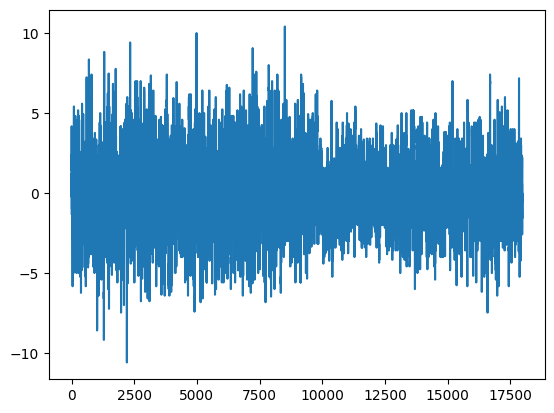

In [232]:
plt.plot(0.588*delta('B', 10)[:-5] - delta('E', 10)[5:])

If B changes by x, then E changes by 0.588*x after 5 ticks (on average).

We can exploit the very large noise by calculating expected prices of E using data from B, buying when buy price is below what our model predicts, and selling when sell price is above what our model predicts. Since there's unlimited liquidity provided at the server-generated prices, we can max out our position limit wihtout worrying about the order book.

Unfortunately my brain worked too much before and did not have enough remaining capacity to implement this in the competition :(

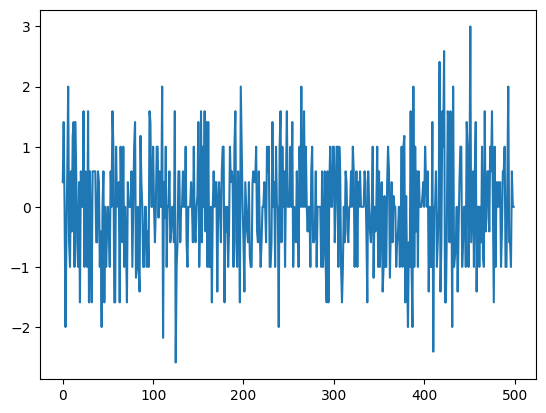

In [ ]:
plt.plot((0.588*delta('B', 1)[:-5] - delta('E', 1)[5:])[:500])

In [237]:
modelE_2 = linear_model.LinearRegression().fit(timelag('B', 0)[:-5].reshape(-1, 1), timelag('E', 0)[5:])

print(modelE_2.coef_)
print(modelE_2.intercept_)
print(pearsonr(modelE_2.predict(timelag('B', 0)[:-5].reshape(-1, 1)), timelag('E', 0)[5:]))

[1.41279819]
-36.83237205153458
PearsonRResult(statistic=np.float64(0.6639345197161975), pvalue=np.float64(0.0))


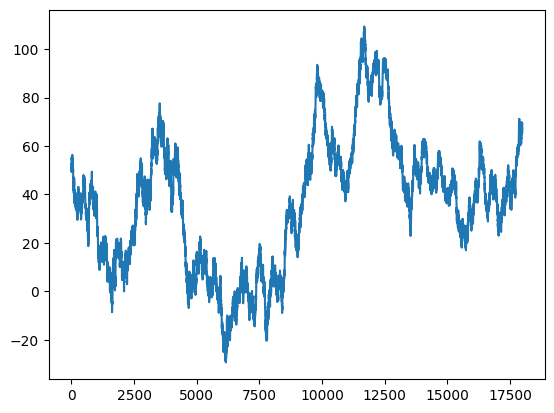

In [236]:
plt.plot(1.412*timelag('B', 5) - timelag('E', 0)[5:])

Here, we find out that stock C is actually an ETF of stocks A and B. I took deltas but still was able to find this real-time, non-delta relationship, so I thought that was cool.

There's a lot of random code that I wrote that I have no idea what I used it for, or what it did. If this were not a time-crunched trading competition, I definitely would have documented everything... maybe.

In [167]:
stock = 'C'
ticks = 5
data = {'A': delta('A', ticks), 'B': delta('B', ticks), 'C': delta('C', ticks), 'E': delta('E', ticks)}
del data[stock]
df = pd.DataFrame(data, columns=[*'ABCE'].remove(stock))
etf_generator = linear_model.LinearRegression()
etf_generator.fit(df, delta(stock, ticks))

from scipy.stats import pearsonr
print(etf_generator.coef_)
print(etf_generator.intercept_)
print(pearsonr(etf_generator.predict(df), delta(stock, ticks)).correlation)

[ 3.74852800e-01  5.60402740e-01 -4.11539371e-06]
-0.0042958605589400786
0.89524009610083


In [ ]:
def findBestCorr(stock):
    max_corr = 0
    tocks = 0
    for ticks in range(50):
        data = {'A': delta('A', ticks), 'B': delta('B', ticks), 'C': delta('C', ticks), 'E': delta('E', ticks)}
        del data[stock]
        df = pd.DataFrame(data, columns=[*'ABCE'].remove(stock))
        etf_generator = linear_model.LinearRegression()
        etf_generator.fit(df, delta(stock, ticks))

        from scipy.stats import pearsonr
        corr = pearsonr(etf_generator.predict(df), delta(stock, ticks)).correlation
        if corr > max_corr:
            max_corr = corr
            tocks = ticks
    return max_corr, tocks

In [169]:
findBestCorr('C')

C:\Users\lukex\AppData\Local\Temp\ipykernel_11484\1270851106.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(etf_generator.predict(df), delta(stock, ticks)).correlation


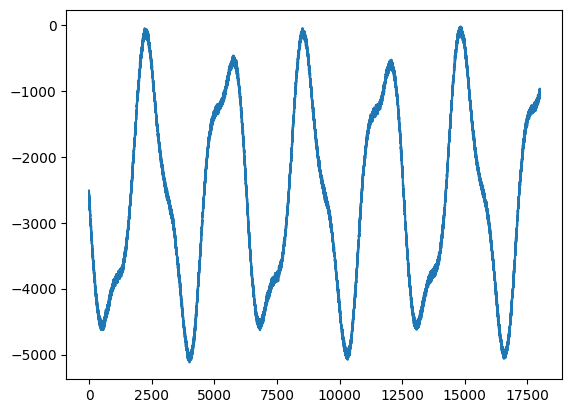

In [180]:
plt.plot(39*prices[f'StockA_Price'] + 58*prices[f'StockB_Price']-100*prices['StockC_Price'])

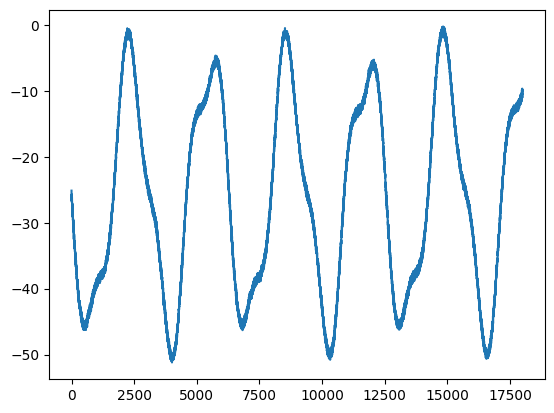

In [179]:
c_etf = 0.39*prices[f'StockA_Price'] + 0.58*prices[f'StockB_Price']
plt.plot(c_etf-prices[f'StockC_Price'])